# Computing $\rho_\odot$ and local VDFs of MW using fiducial mass model parameter range for MW and obtaining $\Delta m_\mathrm{int}$

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import json,os,sys
sys.path.append('..')
from tqdm.notebook import tqdm
import matplotlib
from tabulate import tabulate
from project import profiles as pp
from project.constants import Constants as pc
from project.energetics import EI_vdf as EI
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
matplotlib.rcParams['font.family'] = 'sans-serif'

# Computing the fiducial range of MW's stellar disc from the thick and thin discs in McMillian 2017 paper

From 1st order approximation: 
 Σd,star = 1043.4 +- 175.1    Rd,star = 2.7 +- 0.9
From best fit exponential function: 
 Σd,star = 867.1 +- 175.1     Rd,star = 3.1 +- 0.9


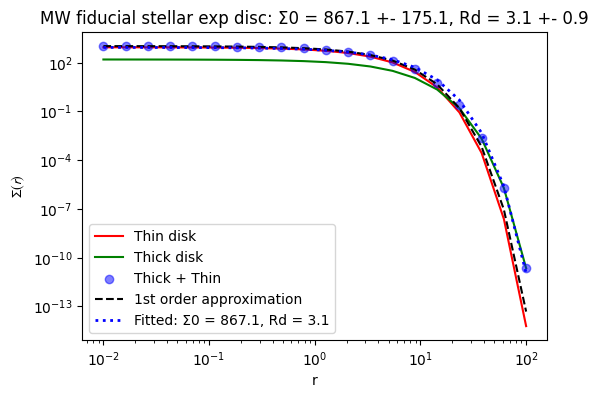

In [5]:
# All discs are modelled as exponential function of the form:
expfn = lambda x,A,a: A*np.exp(-x/a)
x = np.logspace(-2,2,20)

# A and a corresponds to Σ0 and Rd of thick stellar disc and B, b corresponds to thin disc as per McMillian 2017
A = 886.7
B = 156.7
a = 2.53
b = 3.38

# C and c are linear approximation of Σ0 and Rd 
C = A+B
c = (A*a + B*b)/(A+B)

# For the error on these best fit values 1st order approximation is used (i.e, error on C and c)
ΔA = 116.2
Δa = 0.14
ΔB = 58.9
Δb = 0.54
ΔC = ΔA + ΔB
Δc = c*( ((ΔA + Δa)/(A*a)) + ((ΔB + Δb)/(B*b)) + ((ΔA+ΔB)/(A+B)) )

print (f'From 1st order approximation: \n Σd,star = {C:.1f} +- {ΔC:.1f}    Rd,star = {c:.1f} +- {Δc:.1f}')

# Alternatively obtain D and d, the best fit values for Σ0 and Rd (Note error is still cosidered from 1st order approximations)
fitfn = lambda x,A,a: np.log10(expfn(x,A,a))
y = np.log10(expfn(x,A,a)+expfn(x,B,b))
popt,pcov = sp.optimize.curve_fit(fitfn,x,y,p0 = [1,1])
D,d = popt
print (f'From best fit exponential function: \n Σd,star = {D:.1f} +- {ΔC:.1f}     Rd,star = {d:.1f} +- {Δc:.1f}')

Mmax = 2*np.pi*1042*(4.0)**2
Mmin = 2*np.pi*692*(2.2)**2
# print ('Md in [%.1f, %.1f] '%(Mmin,Mmax))

fig,ax = plt.subplots(figsize = (6,4))

plt.title('MW fiducial stellar exp disc: Σ0 = %.1f +- %.1f, Rd = %.1f +- %.1f'%(D,ΔC,d,Δc))

ax.plot(x,expfn(x,A,a),c = 'r',zorder = 0,label = 'Thin disk')
ax.plot(x,expfn(x,B,b),c = 'g',zorder = 0,label = 'Thick disk')
ax.scatter(x,expfn(x,A,a) + expfn(x,B,b), c = 'b',zorder = 1,alpha = 0.5,label = 'Thick + Thin')
ax.plot(x,expfn(x,C,c),c = 'k',zorder = 2,ls = '--',label = '1st order approximation')


ax.plot(x,expfn(x,D,d),c = 'b',zorder = 3,ls = ':',lw = 2,label = 'Fitted: Σ0 = %.1f, Rd = %.1f'%(D,d))

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r')
ax.set_ylabel('$\Sigma(r)$');

In [6]:
# Fiducial ranges for the massmodel of MW (Considering NFW + Stellar EXP disc + Gas EXP disc + Bulge EXP disc)
MW = {'m200':[0.9,1.6],
      'c200':[9.0,17.0],
      'mdstar':[42.0,63.0],
      'mdbul':[8.0,20.0],
      'mdgas':[1.0,20.0],
      'rdstar':[2.0,4.0],
      'rdbul':[1.9,2.0],
      'rdgas':[5.0,20.0]}

In [7]:
def mwmassmodel(Nmocks, MW=MW):
    """
    Sampling Nmocks mass models(θ) from θ_mean = (θ_max + θ_min)/2 and 
    θ_std = (θ_max - θ_min)/2. The θ distribution is a truncated gaussian 
    distribution centered at θ_mean with a width of θ_std and truncated at 
    the fiducial range for all parameters except C200 for which the truncation 
    is done at θ_mean +- 2xθ_std 
    ----------
    Nmocks: (int) number of mass model samples required
    MW: (dict) Contaning the fiducial range for MW mass models (θ), defaul = MW 
    """
    def truncated_normal(limits,scale = 1,seed = 3000):
        """
        Function to return random numbers samples from a truncated gaussian distribution
        truncated at end points specified by limits. The mean and standard deviation are
        obtained from limits.
        ----------
        limits: (list) A list containing two elements, the min and max parameter range in 
        floats
        scale: (float) This decides how much the factor by which the fiducial range has 
        to be extended (and hence truncated at different end points than what limit 
        specifies
        seed: (int) seed for random number generator
        """
        np.random.seed(seed)
        
        min_limit, max_limit = limits
        mean = (max_limit + min_limit)/2.0
        std = (max_limit - min_limit)/2.0
        trunc_min, trunc_max = mean - scale*std, mean + scale*std
        a = (trunc_min - mean)/std
        b = (trunc_max - mean)/std
        # print (f'mean,std = ({mean:.1f}, {std:.1f})')
        # print (f'min,max = ({min_limit:.1f}, {max_limit:.1f})')
        # print (f'trunc at = ({trunc_min:.1f}, {trunc_max:.1f})')
        # print (f'a,b = ({a:.1f}, {b:.1f})')
        
        #generating Nmock number of samples
        random_numbers = sp.stats.truncnorm.rvs(a, b, loc=mean, scale=std, size=Nmocks)
        return random_numbers
        
    massmodels = []
    for key in MW.keys():
        # Considering twice the range of c200 of mw for comparability with MW-like galaxies
        scale = 2 if key == 'c200' else 1
        massmodels.append(truncated_normal(MW[key],scale))
    return np.array(massmodels)

In [8]:
Nmocks = 1000
massmodels = mwmassmodel(Nmocks)
print (f'shape of massmodels: {massmodels.shape}')

shape of massmodels: (8, 1000)


# Display the sampled mass model parameters

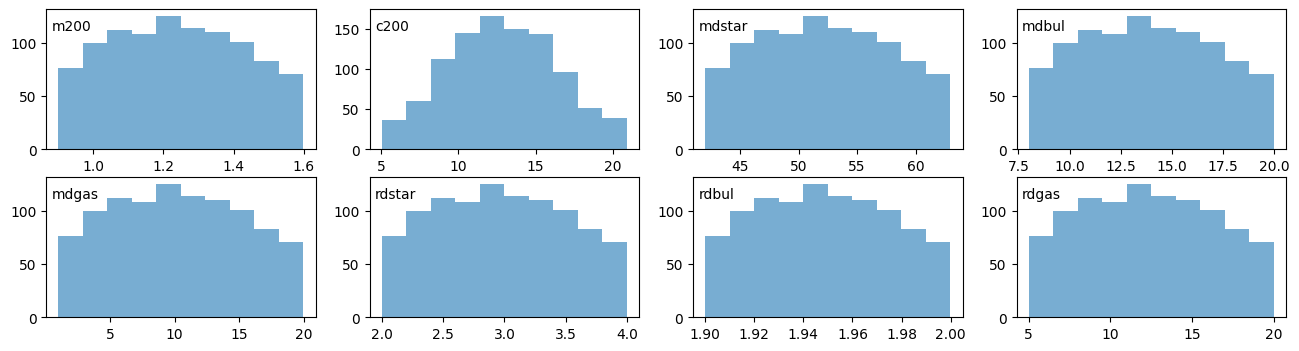

In [294]:
fig,axs = plt.subplots(2,4,figsize = (16,4))
axs = axs.flatten()
for i in range(len(list(MW.keys()))):
    ax = axs[i]
    ax.hist(massmodels[i],alpha = 0.6)
    ax.text(0.02,0.85,list(MW.keys())[i],transform = ax.transAxes)

# plt.savefig('../Output/figures/MW_massmodel_samples.pdf',bbox_inches = 'tight',dpi = 300)

# Computing the corresponding range of $\rho_\odot$.

16th percentile value: 0.3 
84th percentile value: 0.6


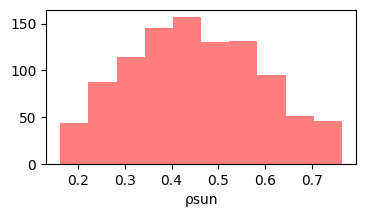

In [295]:
mwρsuns = []
for i in range(Nmocks):
    lm = np.log10(massmodels[0][i]) + 12
    c200 = massmodels[1][i]
    rs = pp.rs_nfw(lm, c200)
    ρsun = pp.density_nfw(lm,rs,8.0)
    mwρsuns.append(ρsun/pc.GeV_by_cc)
# print (f"{np.mean(mwρsuns):.1f} +- {np.std(mwρsuns):.1f} ({Nmocks:.0f} samples)")

print (f'16th percentile value: {np.percentile(np.sort(mwρsuns),16):.1f} \n84th percentile value: {np.percentile(np.sort(mwρsuns),84):.1f}')

fig,ax = plt.subplots(figsize = (4,2))
ax.hist(mwρsuns,alpha = 0.5,color = 'r')
ax.set_xlabel('ρsun')

# plt.savefig('../Output/figures/MW_rhosun_distribution.pdf',bbox_inches = 'tight',dpi = 300)

# Computing the local VDFs of these massmodels

In [50]:
VDFs = []
Vescs = []
for i in tqdm(range(Nmocks)):
    massmodel = massmodels[:,i]
    lm = np.log10(massmodel[0]) + 12
    c200 = massmodel[1]
    rs = pp.rs_nfw(lm, c200)
    lmdstar = np.log10(massmodel[2]) + 9
    lmdbul = np.log10(massmodel[3]) + 9
    lmdgas = np.log10(massmodel[4]) + 9
    rdstar = massmodel[5]
    rdbul = massmodel[6]
    rdgas = massmodel[7]
    model = {'dm':['NFW',lm,rs],
             'disk':['EXP',lmdstar,rdstar],
             'gas':['EXP',lmdgas,rdgas],
             'bulge':['EXP',lmdbul,rdbul]}
    ei = EI(model)
    vdf = ei.get_vdf(r=8.0, n=32)
    vesc = ei.Vmax(r=8.0)
    VDFs.append(vdf)
    Vescs.append(vesc)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Obtain the 68% and 95% envelopes of the VDFs 

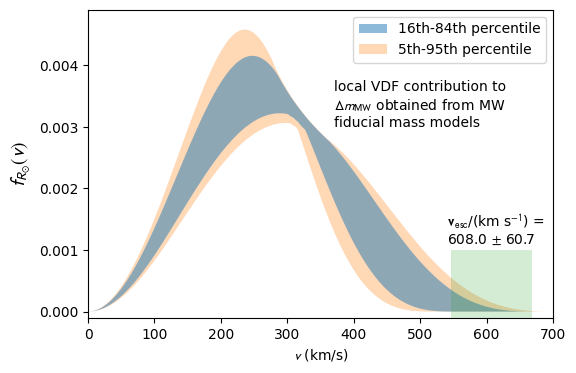

In [296]:
vesc_mean = np.percentile(Vescs, 50)
vesc_err = 0.5*(np.percentile(Vescs, 84) - np.percentile(Vescs, 16))
v = np.linspace(0,np.max(Vescs),200)

vdffn = lambda v_,vdf,v=v: sp.interpolate.interp1d(v_,vdf,kind = 'cubic',bounds_error = False, fill_value = 0,assume_sorted = True)(v)
vdfs_ = np.array([vdffn(vdf[:,0],vdf[:,1]) for vdf in VDFs])
filternan = lambda vdfs: vdfs[~np.any(np.isnan(vdfs), axis = 1)] 
vdfs = filternan(vdfs_)

vdf_m = np.array([np.percentile(vdfs[:,i], 50) for i in range(len(v))])
vdf_16_84 = np.array([np.percentile(vdfs[:,i], (16,84)) for i in range(len(v))])
vdf_05_95 = np.array([np.percentile(vdfs[:,i], (5,95)) for i in range(len(v))])

fig,ax = plt.subplots(figsize = (6,4))
ax.fill_between(v,vdf_16_84[:,0],vdf_16_84[:,1],alpha = 0.5,zorder = 1,label = '16th-84th percentile')
ax.fill_between(v,vdf_05_95[:,0],vdf_05_95[:,1],alpha = 0.3,zorder = 0,label = '5th-95th percentile')

ax.set_xlim(0,700)
ax.set_ylim(-1e-4,4.9e-3)
ax.fill_between(np.percentile(Vescs,(16,84)),[-1e-4,-1e-4],[1e-3,1e-3],alpha = 0.2)
ax.text(540,1.1e-3,'$\mathbf{v_\mathrm{\,esc}}$/(km s$^{-1}$) = \n'+f'{vesc_mean:.1f} $\pm$ {vesc_err:.1f}' , size = 10)

ax.legend()
ax.set_xlabel('$v$ (km/s)')
ax.set_ylabel('$f_{R_{\odot}}(v)$',size = 14)
ax.text(370,0.003, 'local VDF contribution to \n$\Delta m_\mathrm{MW}$ obtained from MW \nfiducial mass models');

# plt.savefig('../Output/figures/MW_local_VDF_distribution.pdf',bbox_inches = 'tight', dpi = 300)

In [233]:
# Saving data to output
import pickle
MW_dict = {'fiducial_range':MW,
           'massmodels':{list(MW.keys())[i]:massmodels[i] for i in range(len(list(MW.keys())))},
           'VDFs':VDFs,
           'vdfs_massmodel':{'Vescs':Vescs,
                             'v':v,
                             'vdf_16_84':vdf_16_84,
                             'vdf_05_95':vdf_05_95}
          }
with open('../Output/MW_dict.pkl','wb') as outf:
    # pickle.dump(MW_dict, outf)
outf.close;